In [1]:
 ### import useful libraries

import os
import numpy as np
import obspy 
from obspy import UTCDateTime
from obspy import read, read_inventory
from obspy.core.inventory import Inventory, Network, Station, Channel, Site 
from obspy.core.inventory.util import Equipment
from obspy.clients.nrl import NRL 
from obspy.signal.invsim import cosine_taper 
from obspy.signal import cross_correlation
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import datetime

In [2]:
def calculate_baz_horiz(st_rot, overlap, fmin, periods_per_window, st_acc=0, filen='0'):
    """
    Function to calculate baz from horizontal location, ambiguity of 180 degree.
    author: Shihao Yuan: Yuan et al. 2020, BSSA
    modified: Eva Eibl
    working: checked by Eva Eibl 9/2/2021
    TODO: remove amplitude and xcorr thresholds, add linearity as better measure for quality of BAZ

    :type st_rot: stream object
    :param st_rot: 3 component rotation rate data labelled HJ1, HJ2, HJ3 or HJE, HJN, HJZ (unit rad/s)
    :type overlap: integer
    :param overlap: overlap in seconds
    :type fmin: integer
    :param fmin: minimum frequency in Hz
    :type periods_per_window: integer
    :param periods_per_window: number of periods per window
    :type st_acc: stream object
    :param st_acc: 3 component acceleration data (seismometer) (unit m/s2)
    :type filen: string
    :param filen: path to save file

    return time vector, baz vector
    """
    t_range = int(len(st_rot[0].data)/st_rot[0].stats.sampling_rate)
    winlen = 1/fmin * periods_per_window
    dt = st_rot[0].stats.delta
    num_win = int ((t_range/winlen*(1/overlap)) + 1)  # number of time windows
    baz_cal = []
    t = []
    xcorrval = []
    linearity = []

    if st_acc!=0:
        # get st_rot & st_acc to have same start and endtime
        if st_acc[0].stats.endtime > st_rot[0].stats.endtime:
            end2 = st_rot[0].stats.endtime
        else:
            end2 = st_acc[0].stats.endtime
        #end
        if st_acc[0].stats.starttime > st_rot[0].stats.starttime:
            start2 = st_acc[0].stats.starttime
        else:
            start2 = st_rot[0].stats.starttime
        #end
        st_acc.trim(start2, end2)
        st_rot.trim(start2, end2)
    #end

    if st_rot[0].stats.channel=='HJ1':
       st_rot[0].stats.channel = 'HJE'
    if st_rot[1].stats.channel=='HJ2':
       st_rot[1].stats.channel = 'HJN'
    if st_rot[2].stats.channel=='HJ3':
       st_rot[2].stats.channel = 'HJZ'

    for step in np.linspace(0, t_range, num_win): #0, 60,..., 86280
        # Define time window in s and samples 
        t1 = 0 + step       # s               0   60
        t2 = t1 + winlen    # s               60  120
        t3 = int(t1/dt)  # samples         0   12000
        t4 = int(t2/dt)  # samples     12000   24000

        # zero data initialization & time window extraction
        data = (np.zeros((t4-t3, 2)))
        if len(data[:, 0])==len(st_rot.select(channel="HJE")[0].data[t3:t4]):
            data[:, 0] = st_rot.select(channel="HJE")[0].data[t3:t4] #E
            data[:, 1] = st_rot.select(channel="HJN")[0].data[t3:t4] #N

            # calculate absolute of data, not necessary 
            d0 = np.abs(data[:, 0])
            d1 = np.abs(data[:, 1])

            # calculate max ampl of whole day & mean ampl of window
            amp_data = np.mean([np.max(st_rot.select(channel="HJE")[0].data), np.max(st_rot.select(channel="HJN")[0].data)])
            amp_win  = np.mean([d0, d1]) 

            # correlate normalised N & E window  &  normalise value by dividing by (summe Nampl * summe Eampl)
            coef1 = np.correlate(d1/np.max(d1), d0/np.max(d0)) / np.sqrt(((d1/np.max(d1))**2).sum() * ((d0/np.max(d0))**2).sum())
            # ampl in window needs to be large enough & correlation high enough
            #if ( amp_win > amplthres*amp_data and coef1 > corrthres):  # Etna above 0.5
            # -- Polarization using SVD --
            # calculate covariance matrix
            if(1): # Eva & Shihao from 2019 - working
                C = np.cov(data, rowvar=False)
                # calculate eigenvalues (Cprime) and eigenvectors (Q)
                eigenval, eigenvec = np.linalg.eigh(C, UPLO='U')
                # sort eigenvector according to eigenvalues in ascending order
                loc = np.argsort(np.abs(eigenval))
                eigenval = eigenval[loc]
                eigenvec = eigenvec[:, loc]
                # calculate baz using eigenvector of smallest eigenvalue
                #baz_tmp = np.arctan(np.abs(eigenvec[1, 0]/eigenvec[0, 0])) * 180 / np.pi # shihao  only 0-90 deg
                #baz_tmp = baz_tmp + 270                                                  # shihao
                baz_tmp = np.arctan2(eigenvec[1, 0], eigenvec[0, 0])/np.pi*180.           # eva
                baz_tmp = 90 - baz_tmp            # eva  convert math angle to baz

                if baz_tmp<0:
                    baz_tmp = baz_tmp+360
                #end
            #end

            ## -- calculate Geradlinigkeit --
            eigw_mid = np.min(eigenval)
            eigw_max = np.max(eigenval)
            Flin = 1-np.sqrt(eigw_mid/eigw_max)

            # To remove the $180^\circ$ ambiguity, 
            # we then compare the rotated transverse component of rotation to 
            # the negative vertical component of acceleration (i.e. Az*(-1)) 
            # If the correlation coefficient is negtive, 180 degree will be added to baz_tmp.
            if st_acc!=0:
                if(len(st_acc[2].data[t3:t4])==len(data[:, 1])):
                    cc = correlate(-st_acc[2].data[t3:t4], 
                            rotate_ne_rt(data[:, 1], data[:, 0], baz_tmp)[1][:], shift=0)  #E 
                    shift, mcor = xcorr_max(cc)
                    if (np.sign(mcor) < 0):
                        baz_tmp = 180 +  baz_tmp 
                    #end
                #end
            #end
            if baz_tmp>360:
                baz_tmp = baz_tmp-360
            #end

            baz_cal.append(baz_tmp)
            t.append(t1+winlen/2.)
            xcorrval.append(coef1)
            linearity.append(Flin)
        #end
    #end
    
    baz_cal = np.array(baz_cal)
    t = np.array(t)
    linearity = np.array(linearity)

    if(filen != '0'):  ## -- save BAZ for horizontal location in file -- 
        tstart = st_rot[0].stats.starttime
        filename = f'{filen}.csv'
        exists = False
        if os.path.exists(filename):
            exists = True
        with open(filename, 'a+') as resfile:
            if not exists:
                resfile.write('Date,Baz,xcorrval,linearity\n')
            for i in range(len(t)):
                twindow = tstart + t[i]
                resfile.write(str(pd.Timestamp(twindow.year, twindow.month, twindow.day, twindow.hour, twindow.minute, twindow.second))+ ',' +str(baz_cal[i])+ ','+str(xcorrval[i][0])+','+str(linearity[i])+'\n')
            #end
    #end

    return baz_cal, t, xcorrval, winlen, linearity

def plot_particle_motion_2D(ax, data_x, data_y, label_x, label_y):
    """
    Function to plot the 2D motion of a particle on a given axis.
    This function creates a 2D line plot of particle motion data, ensuring that the x and y axes have the same scale. 
    It also sets labels for the x and y axes and adjusts the axis limits to accommodate the range of the data with added padding.
    
    :type ax: matplotlib.axes.Axes
    :param ax: The matplotlib Axes object on which to plot the data.
    :type data_x: array-like
    :param data_x: Array-like object containing the x-coordinates of the particle's motion.
    :type data_y: array-like
    :param data_y: Array-like object containing the y-coordinates of the particle's motion.
    :type label_x: str
    :param label_x: Label for the x-axis.
    :type label_y: str
    :param label_y: Label for the y-axis.
    """
    
    ax.plot(data_x, data_y) 
    ax.set_aspect('equal', 'box') 
    ax.set_xlabel(label_x, fontsize=14)
    ax.set_ylabel(label_y, fontsize=14)


    min_data = min(data_x.min(), data_y.min())
    max_data = max(data_x.max(), data_y.max())
    padding = 0.2 * (max_data - min_data)
    min_limit = min(data_x.min(), data_y.min()) - padding
    max_limit = max(data_x.max(), data_y.max()) + padding
    
    ax.set_xlim(min_limit, max_limit)
    ax.set_ylim(min_limit, max_limit)

In [16]:
### load data

events = np.loadtxt("../catalog/initial_LPE_picks", dtype = 'str')
stZ = read("../data/HHZ.D/*")
stN = read("../data/HHN.D/*")
stE = read("../data/HHE.D/*")
st = stE + stN + stZ
print(st)
inv = read_inventory("../data/Stations_Reykjanes2021_RR.xml",format='STATIONXML')
#print(events)

60 Trace(s) in Stream:

RR.SAND.00.HHE | 2024-01-01T00:00:01.189626Z - 2024-01-01T07:57:21.844626Z | 200.0 Hz, 5728132 samples
...
(58 other traces)
...
RR.SAND.00.HHZ | 2024-01-27T23:10:58.847573Z - 2024-01-28T00:00:01.577573Z | 200.0 Hz, 588547 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [4]:
### plotting differently filtered seismogram as comparison

i = 0
for event in events:
    fig1 = plt.figure(figsize=(10, 8), layout='constrained')

    # Plotting 5-15Hz filtered seismogram
    tstart = event[0] + 'T' + event[1]
    stseis = st.copy()
    stseis.trim(UTCDateTime(tstart) - 1, UTCDateTime(tstart) + 40)

    stseis.detrend('demean')
    stseis.detrend('linear')
    stseis.taper(0.1)
    stseis.remove_response(inventory=inv, output="VEL")
    stseis.trim(UTCDateTime(tstart) - 1, UTCDateTime(tstart) + 20)
    stseis_high = stseis.copy()
    stseis_high.filter("bandpass", freqmin=5.0, freqmax=15.0)

    with plt.style.context('ggplot'):
        ax1 = fig1.add_subplot(211)
        ax1.plot(stseis_high[0].times(), stseis_high[0].data, 'k-', linewidth=0.5,
                 label='%s.%s.%s.%s' % (stseis_high[0].stats.network, stseis_high[0].stats.location,
                                        stseis_high[0].stats.station, stseis_high[0].stats.channel))
        ax1.legend(loc='upper right', fontsize = 12)
        ax1.set_title('5-15Hz filtered Seismogram, %s' % str(stseis_high[0].stats.starttime - 1)[:-5], fontsize = 16)
        ax1.set_ylabel('Velocity [m/s]', fontsize = 14)

        # Determine y-axis limits for the upper plot
        ymax_high = max(stseis_high[0].data)
        ymin_high = min(stseis_high[0].data)

    # Plotting 0.5-5Hz filtered seismogram
    stseis.filter("bandpass", freqmin=0.5, freqmax=5.0)

    with plt.style.context('ggplot'):
        ax2 = fig1.add_subplot(212)
        ax2.plot(stseis[0].times(), stseis[0].data, 'k-', linewidth=0.5,
                 label='%s.%s.%s.%s' % (stseis[0].stats.network, stseis[0].stats.location,
                                        stseis[0].stats.station, stseis[0].stats.channel))
        ax2.legend(loc='upper right', fontsize = 12)
        ax2.set_title('0.5-5Hz filtered seismogram, %s' % str(stseis[0].stats.starttime - 1)[:-5], fontsize = 16)
        ax2.set_ylabel('Velocity [m/s]', fontsize = 14)

        # Determine y-axis limits for the lower plot
        ymax_low = max(stseis[0].data)
        ymin_low = min(stseis[0].data)

        # Determine combined y-axis limits
        ymax_combined = max(ymax_high, ymax_low)
        ymin_combined = min(ymin_high, ymin_low)

        # Set the same y-axis limits for both plots
        ax1.set_ylim(ymin_combined, ymax_combined)
        ax2.set_ylim(ymin_combined, ymax_combined)

    # Saving plot
    plt.close(fig1)

    save_name1 = 'seis' + event[0] + '_' + str(i) + '.png'
    fig1.savefig("../figures/comparison/seiscomp/" + save_name1)

    i += 1



In [17]:
### plotting (un)filtered spectrogram as comparison

# defining variables
NFFT = 256
noverlap = 250 
i = 0

for event in events:
    fig1 = plt.figure(figsize=(10, 8), layout = 'constrained')

    #plotting unfiltered spectrogram
    tstart = event[0] + 'T' + event[1]
    stspec = st.copy()
    stspec.trim(UTCDateTime(tstart) - 1, UTCDateTime(tstart) + 40)

    stspec.detrend('demean')
    stspec.detrend('linear')
    stspec.taper(0.1)
    stspec.remove_response(inventory=inv,output="VEL")
    stspec.trim(UTCDateTime(tstart) - 1, UTCDateTime(tstart) + 20)
    
    ax1 = fig1.add_subplot(211)
    ax1.set_title('Unfiltered Spectrogram, %s' % str(stspec[0].stats.starttime - 1)[:-5], fontsize = 16)
    Pxx, freqs, bins, im1 = ax1.specgram(
        stspec[0].data, NFFT=NFFT, Fs=stspec[0].stats.sampling_rate, 
        noverlap=noverlap, cmap=plt.cm.viridis, scale = 'linear')

    ax1.set_xlabel('Relative time [sec]', fontsize = 14)
    ax1.set_ylabel('Frequency [Hz]', fontsize = 14)
    ax1.set_ylim(0,20)
    
    stspec.filter("bandpass", freqmin = 0.5, freqmax = 5.0)
    
    # plotting filtered spectogram
    ax2 = fig1.add_subplot(212, sharex=ax1)
    ax2.set_title('0.5-5Hz filtered Spectrogram, window length %s pts' % NFFT, fontsize = 16)
    Pxx, freqs, bins, im2 = ax2.specgram(
        stspec[0].data, NFFT=NFFT, Fs=stspec[0].stats.sampling_rate, 
        noverlap=noverlap, cmap=plt.cm.viridis, scale = 'linear')

    ax2.set_xlabel('Relative time [sec]', fontsize = 14)
    ax2.set_ylabel('Frequency [Hz]', fontsize = 14)
    ax2.set_ylim(0,5)
    
    # Create a single colorbar that spans both subplots
    cbar = fig1.colorbar(im2, ax=[ax1, ax2], orientation='vertical', fraction=0.05)
    cbar.set_label(r'Power spectral density $[(m/s)^2/Hz]$', fontsize=12)
    
    plt.close(fig1)

    save_name3 = 'spec_' +event[0] + '_' + str(i) + '.png'
    fig1.savefig("../figures/comparison/speccomp/" + save_name3)

    i += 1



In [18]:
# plotting seismogram, spectrogram, and particle motion of good events

#load revised catalog
events = np.loadtxt("../catalog/revised_LPE_picks", dtype = 'str')

# defining variables
NFFT = 256
noverlap = 250 
i = 0

for event in events:
    tstart = event[0] + 'T' + event[1]
    stcomp = st.copy()
    stcomp.trim(UTCDateTime(tstart) - 1, UTCDateTime(tstart) + 60)

    stcomp.detrend('demean')
    stcomp.detrend('linear')
    stcomp.taper(0.1)
    stcomp.remove_response(inventory=inv,output="VEL")
    stcomp.trim(UTCDateTime(tstart) - 1, UTCDateTime(tstart) + 20)
    stcomp.filter("bandpass", freqmin = 0.5, freqmax = 5.0)
    
    fig1 = plt.figure(figsize=(10, 8), layout = 'constrained')
    
    # plotting seismogram
    with plt.style.context('ggplot'):
        ax1 = fig1.add_subplot(211)
        ax1.plot(stcomp[0].times(), stcomp[0].data, 'k-', linewidth=0.5, label='%s.%s.%s.%s' % (stcomp[0].stats.network, stcomp[0].stats.location, stcomp[0].stats.station, stcomp[0].stats.channel))
        #ax1.axvline(x = 1, ymin = 0.4, ymax = 0.6, color = 'red', linestyle = '-', linewidth = '1.0', label = 'P wave')
        ax1.legend(loc='upper right', fontsize = 12)
        ax1.set_title('%s' % str(stcomp[0].stats.starttime - 1)[:-5], fontsize = 16)
        ax1.set_ylabel('Velocity [m/s]', fontsize = 14)
        ymax = max(stcomp[0].data)
        ymin = -ymax
        ax1.set_ylim(ymin, ymax)
    
    # plotting spectogram
    ax2 = fig1.add_subplot(212, sharex=ax1)
    ax2.set_title('Spectrogram, window length %s pts' % NFFT, fontsize = 16)
    Pxx, freqs, bins, im = ax2.specgram(
        stcomp[0].data, NFFT=NFFT, Fs=stcomp[0].stats.sampling_rate, 
        noverlap=noverlap, cmap=plt.cm.viridis, scale = 'linear')

    ax2.set_xlabel('Relative time [sec]', fontsize = 14)
    ax2.set_ylabel('Frequency [Hz]', fontsize = 14)
    ax2.set_ylim(0,5)
    
    cbar = fig1.colorbar(im, ax=ax2)
    cbar.set_label(r'Power spectral density $[(m/s)^2/Hz]$')
    
    plt.close(fig1)

    save_name1 = event[0] + '_' + str(i) + '.png'
    fig1.savefig("../figures/seis_spec/" + save_name1)

    stcomp_pm = stcomp.copy()
    stcomp_pm.trim(UTCDateTime(tstart), UTCDateTime(tstart) + 1.0)
    
    # plotting particle motion
    fig2, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Plot the particle motion with appropriate labels
    plot_particle_motion_2D(ax1, stcomp_pm[0].data, stcomp_pm[1].data, 'HHE', 'HHN')
    plot_particle_motion_2D(ax2, stcomp_pm[2].data, stcomp_pm[1].data, 'HHZ', 'HHN')
    plot_particle_motion_2D(ax3, stcomp_pm[0].data, stcomp_pm[2].data, 'HHE', 'HHZ')

    # Set the title for the entire figure
    fig2.suptitle('Particle Motion of Event %s' % str(stcomp_pm[0].stats.starttime - 1)[:-5], fontsize = 16)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the title
    plt.close(fig2)

    # Save the figure
    save_name2 = event[0] + '_' + str(i) + '.png'
    fig2.savefig("../figures/particlemotion/" + save_name2)

    i += 1

In [10]:
### plot events in time

events = np.loadtxt("../catalog/revised_LPE_picks", dtype = 'str')

# Plotting the histogram
event_times = []
for event in events:
    times = event[0] + ' ' + event[1]
    event_times.append(times)
    
event_dates = [datetime.datetime.strptime(event, '%Y-%m-%d %H:%M:%S.%f') for event in event_times]
start_date = datetime.datetime(2024, 1, 1)
end_date = datetime.datetime(2024, 2, 1)
dates = [start_date + datetime.timedelta(days=i) for i in range((end_date - start_date).days)]
event_counts = [sum(1 for event in event_dates if event.date() == date.date()) for date in dates]

fig1 = plt.figure(figsize=(10, 8))

ax1 = fig1.add_subplot(211)
ax1.bar(dates, event_counts, width=1, align='edge', edgecolor='black')
ax1.set_title('Number of Events per Day in January 2024', fontsize = 16)
ax1.set_xlabel('Date', fontsize = 14)
ax1.set_ylabel('Number of Events', fontsize = 14)
ax1.tick_params(axis='x', rotation=0)

# plotting events from the 14th
january_14_events = [event for event in event_dates if event.date() == datetime.date(2024, 1, 14)]
hours = range(0, 24)
event_counts_hourly = [sum(1 for event in january_14_events if event.hour == hour) for hour in hours]

ax2 = fig1.add_subplot(212)
ax2.bar(hours, event_counts_hourly, width=0.8, align='center', edgecolor='black')
ax2.set_title('Number of Events per Hour on January 14, 2024', fontsize = 16)
ax2.set_xlabel('Hour of the Day', fontsize = 14)
ax2.set_ylabel('Number of Events', fontsize = 14)
ax2.set_xticks(hours)
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig("../figures/" + "events_over_time")
plt.close(fig1)

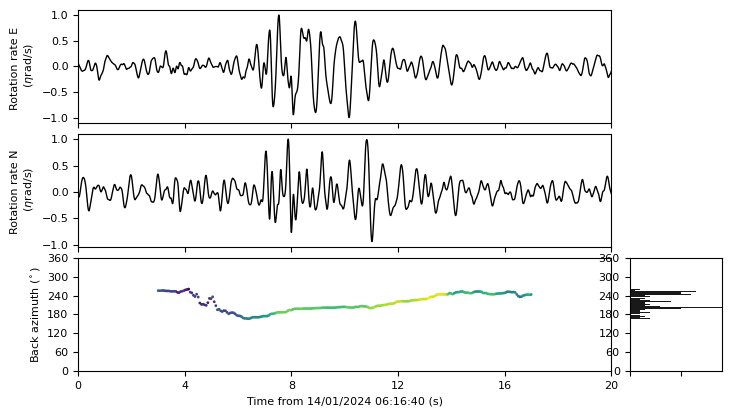

In [28]:
### baz calculation

st1 = read(f"../data/SVA/SVA//HJ1.D/XX.XB102.00.HJ1.D.2024.014")
st2 = read(f"../data/SVA/SVA//HJ2.D/XX.XB102.00.HJ2.D.2024.014")
st3 = read(f"../data/SVA/SVA//HJ3.D/XX.XB102.00.HJ3.D.2024.014")
st_rot = st1 + st2 + st3 

## -- define properties to read in data --
periods_per_window = 3
fmin = 0.5
fmax = 5
tstart = UTCDateTime(2024, 1, 14, 6, 16, 40)
tend = UTCDateTime(2024, 1, 14, 6, 17, 00)
wlen = tend - tstart
tend_late = tend + 1 * 60
tstart_early = tstart - 1 * 60
        
st_rot.merge(method=1, fill_value='interpolate')
st_rot.trim(tstart_early, tend_late)
st_rot.detrend('demean')
st_rot.detrend('linear')
st_rot.taper(0.01)
#     stcopy.remove_response(inventory=inv, output="VEL")
st_rot.filter("bandpass", freqmin=0.5, freqmax=3.0)
st_rot.trim(tstart, tend)
st_rot.normalize()

if len(st_rot)>0:
    st_rot[0].data = st_rot[0].data * 1e-9 # rad/s
    st_rot[1].data = st_rot[1].data * 1e-9 # rad/s
    st_rot[2].data = st_rot[2].data * 1e-9 # rad/s

    overlap = 0.01
    baz_cal, t, xcorr, win, lin = calculate_baz_horiz(st_rot, overlap, fmin, periods_per_window, 0)

    ## -- plot rotation E, rotation N, baz for EQ --
    plt.figure(figsize=(7.48, 4))
    matplotlib.rcParams.update({'font.size': 8})
    ax = plt.subplot2grid((3, 6), (0, 0), colspan=5)

    ## -- plotting rotation E --
    ax.plot(st_rot[0].data*1.e9, 'k', lw=1)
    ax.set_ylabel('Rotation rate E \n ($\eta$rad/s)')
    ax.set_xticks(np.arange(0, wlen*st_rot[1].stats.sampling_rate+wlen, st_rot[2].stats.sampling_rate*4))
    ax.set_xlim(0, wlen*st_rot[1].stats.sampling_rate)
    #ax.axvline(0.75*wlen*st_rot[1].stats.sampling_rate, ls = "--", color="g")
    ax.axvline(0.75*wlen*st_rot[1].stats.sampling_rate+win*st_rot[1].stats.sampling_rate, ls = "--", color="g")
    #ax.set_ylim(-1000, 1000)
    plt.setp(ax.get_xticklabels(), visible=False)
    
    ## -- plotting rotation N --
    ax0 = plt.subplot2grid((3, 6), (1, 0), colspan=5)
    ax0.plot(st_rot[1].data*1.e9, 'k', lw=1)
    ax0.set_ylabel('Rotation rate N \n ($\eta$rad/s)')
    ax0.set_xticks(np.arange(0, wlen*st_rot[1].stats.sampling_rate+wlen, st_rot[2].stats.sampling_rate*4))
    ax0.set_xlim(0, wlen*st_rot[1].stats.sampling_rate)
    #ax0.set_ylim(-1000, 1000)
    plt.setp(ax0.get_xticklabels(), visible=False)

    ## -- plotting baz
    ax1 = plt.subplot2grid((3, 6), (2, 0), colspan=5)
    ax1.scatter(t, baz_cal, c=xcorr, s=1, label='Estimated Baz using Re and Rn')
    ax1.set_xlabel('Time from '+ str("%02d" % tstart.day) + '/'+ str("%02d" % tstart.month) +
                    '/2024 '+ str("%02d" % tstart.hour) +':'+ str("%02d" % tstart.minute) +
                    ':'+ str("%02d" % tstart.second) + ' (s)')
    ax1.set_ylabel('Back azimuth ($^\circ$)')
    ax1.set_ylim(0, 360)
    ax1.set_xticks(np.arange(0, 62, 4)) #alle 4s
    ax1.set_yticks(np.arange(0, 420, 60))
    ax1.set_xlim(0, wlen)

    ## -- plot baz histogram --
    n, bins, patches = plt.hist(baz_cal, np.arange(0, 360, 2),
                        facecolor='k', alpha=0.00001, orientation='horizontal')
    Az_dom = ((bins[np.argmax(n)]+bins[np.argmax(n)+1])/2.)

    ax2 = plt.subplot2grid((3, 6), (2, 5))
    ax2.hist(baz_cal, np.arange(0, 360, 2), facecolor='k', alpha=0.9, orientation='horizontal')
    ax2.xaxis.set_ticklabels([])
    #ax2.grid(True)
    ax2.set_xlim(np.min(n), np.max(n))
    ax2.set_yticks(np.arange(0, 420, 60))
    ax2.set_ylim(0, 360)

    ## -- adjust and save
    plt.subplots_adjust(top=0.99, bottom=0.088, left=0.12, right=0.98, hspace=0.1)
    #plt.savefig(f"{localpath}/2_BAZ_EQ/{fmin}_{fmax}/BAZ_2019_{tstart.month}_{tstart.day}_h{tstart.hour}-{tstart.minute}-{tstart.second}_f{fmin}-{fmax}_{stat}_Shihao.png", format='png', dpi=300)  #EQ/
    plt.savefig('../figures/BAZ.png')
    plt.show()
    #plt.close()
#end